# Пример использования: генерация имен

In [1]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import sys
from transliterate import translit
from keras import backend as K

Using TensorFlow backend.


In [2]:
def reset_tf_session():
    curr_session = tf.get_default_session()
    # close current session
    if curr_session is not None:
        curr_session.close()
    # reset graph
    K.clear_session()
    # create new session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.InteractiveSession(config=config)
    K.set_session(s)
    return s

## Загрузка датасета

Датасет содержит около 8 000 имен

In [3]:
start_token = " "  # so that the network knows that we're generating a first token

# this is the token for padding,
# we will add fake pad token at the end of names 
# to make them of equal size for further batching
pad_token = "#"

with open("./data/lecture3/names") as f:
    names = f.read()[:-1].split('\n')
    names = [start_token + name for name in names]

In [4]:
print('number of samples:', len(names))
for x in names[::500]:
    print('      ' + x)

number of samples: 7944
       Abagael
       Benedetta
       Claresta
       Eilis
       Glory
       Jonell
       Liliane
       Melody
       Prissie
       Stacy
       Geeta
       Clinten
       Giovanne
       Lawerence
       Piggy
       Tann


In [5]:
' Mark' in names

True

max length: 16


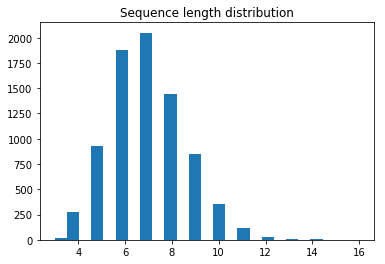

In [6]:
MAX_LENGTH = max(map(len, names))
print("max length:", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.hist(list(map(len, names)), bins=25);

# Преобразуем имена в последовательность чисел

Для этого создадим словарь, который каждому уникальному символу (в нашем случае - букве латинского алфавита) ставит в соответствие число

In [7]:
tokens = list(set([t for name in names for t in name]))
tokens.append(pad_token)

tokens = sorted(tokens)

n_tokens = len(tokens)
print ('n_tokens:', n_tokens)

n_tokens: 56


In [8]:
token_to_id = {token: i_token for i_token, token in enumerate(tokens)}

In [9]:
token_to_id

{' ': 0,
 '#': 1,
 "'": 2,
 '-': 3,
 'A': 4,
 'B': 5,
 'C': 6,
 'D': 7,
 'E': 8,
 'F': 9,
 'G': 10,
 'H': 11,
 'I': 12,
 'J': 13,
 'K': 14,
 'L': 15,
 'M': 16,
 'N': 17,
 'O': 18,
 'P': 19,
 'Q': 20,
 'R': 21,
 'S': 22,
 'T': 23,
 'U': 24,
 'V': 25,
 'W': 26,
 'X': 27,
 'Y': 28,
 'Z': 29,
 'a': 30,
 'b': 31,
 'c': 32,
 'd': 33,
 'e': 34,
 'f': 35,
 'g': 36,
 'h': 37,
 'i': 38,
 'j': 39,
 'k': 40,
 'l': 41,
 'm': 42,
 'n': 43,
 'o': 44,
 'p': 45,
 'q': 46,
 'r': 47,
 's': 48,
 't': 49,
 'u': 50,
 'v': 51,
 'w': 52,
 'x': 53,
 'y': 54,
 'z': 55}

In [10]:
def to_matrix(names, max_len=None, pad=token_to_id[pad_token], dtype=np.int32):
    """Casts a list of names into rnn-digestable padded matrix"""
    
    max_len = max_len or max(map(len, names))
    names_ix = np.zeros([len(names), max_len], dtype) + pad

    for i in range(len(names)):
        name_ix = list(map(token_to_id.get, names[i]))
        names_ix[i, :len(name_ix)] = name_ix

    return names_ix

In [11]:
print('Имена:')
print('\n'.join(names[::2000]))
print('\nКод:')
print(to_matrix(names[::2000]))

Имена:
 Abagael
 Glory
 Prissie
 Giovanne

Код:
[[ 0  4 31 30 36 30 34 41  1]
 [ 0 10 41 44 47 54  1  1  1]
 [ 0 19 47 38 48 48 38 34  1]
 [ 0 10 38 44 51 30 43 43 34]]


# Определяем рекуррентную нейронную сеть (RNN)

Мы можем представить рекуррентную нейронную сеть как последовательное применение Dense слоя к вектору $ x_t $ и предыдущему скрытому состоянию $ h_t $.
<img src="./img/rnn.png" width=600>

При этом нам нужны:
* Embedding layer, который представляет $x_t$ в виде некоторого вектора.
* Output слой, который предсказывает вероятность следующего символа, при условии, что мы уже вычислили $h_{t+1}$

In [12]:
s = reset_tf_session()

In [13]:
import keras
from keras.layers import concatenate, Dense, Embedding

rnn_num_units = 64  # size of hidden state
embedding_size = 16  # for characters

# Let's create layers for our recurrent network

# an embedding layer that converts character ids into embeddings
embed_x = Embedding(n_tokens, embedding_size)

# a dense layer that maps input and previous state to new hidden state, [x_t,h_t]->h_t+1
get_h_next = Dense(units=rnn_num_units, activation='tanh')

# a dense layer that maps current hidden state to probabilities of characters [h_t+1]->P(x_t+1|h_t+1)
get_probas = Dense(units=n_tokens, activation='softmax')

Будем генерировать имя, начиная со `start_token` (в нашем случае - это `' '`):

<img src="./img/char-nn.png" width=600>

In [14]:
def rnn_one_step(x_t, h_t):
    """
    Recurrent neural network step that produces 
    probabilities for next token x_t+1 and next state h_t+1
    given current input x_t and previous state h_t.
    We'll call this method repeatedly to produce the whole sequence.
    
    You're supposed to "apply" above layers to produce new tensors.
    Follow inline instructions to complete the function.
    """
    # convert character id into embedding -
    # будем предсказывать сразу для всего батча одновременно - 
    # а это значит, что берем столбец матрицы с закодированными словами, 
    # а потом делаем reshape, чтобы он все-таки столбцом оставался
    # shape = (batch, 1, embedding_size) - берем нулевую вторую размерность - 
    # получаем: shape = (batch, embedding_size)
    x_t_emb = embed_x(tf.reshape(x_t, [-1, 1]))[:,0,:]
    
    # concatenate x_t embedding and previous h_t state
    # h_t должно иметь ровно тот же shape = (batch, rnn_num_units)
    # тогда x_and_h будет иметь
    # shape = (batch, embedding_size + rnn_num_units)
    x_and_h = concatenate([x_t_emb, h_t])
    
    # compute next state given x_and_h
    h_next = get_h_next(x_and_h)
    
    # get probabilities for language model P(x_next|h_next)
    output_probas = get_probas(h_next)
    
    return output_probas, h_next

# RNN: loop

Чтобы сгенерировать имена, применим `rnn_one_step` несколько раз: при этом имена не могут иметь длину больше $16$


In [15]:
input_sequence = tf.placeholder(tf.int32, (None, MAX_LENGTH))  # batch of token ids
batch_size = tf.shape(input_sequence)[0]

predicted_probas = []
h_prev = tf.zeros([batch_size, rnn_num_units])  # initial hidden state

for t in range(MAX_LENGTH):
    x_t = input_sequence[:, t]  # column t
    probas_next, h_next = rnn_one_step(x_t, h_prev)
    
    h_prev = h_next
    predicted_probas.append(probas_next)
    
# combine predicted_probas into [batch, time, n_tokens] tensor
predicted_probas = tf.transpose(tf.stack(predicted_probas), [1, 0, 2])

# next to last token prediction is not needed
predicted_probas = predicted_probas[:, :-1, :]

Instructions for updating:
Colocations handled automatically by placer.


## Попробуем сгенерировать что-то необученной нейросетью

In [16]:
s.run(tf.global_variables_initializer())

In [17]:
def generate_sample(seed_phrase=start_token, max_length=MAX_LENGTH):
    '''
    This function generates text given a `seed_phrase` as a seed.
    Parameter `max_length` is used to set the number of characters in prediction.
    '''
    x_sequence = [token_to_id[token] for token in seed_phrase]
    s.run(tf.assign(h_t, h_t.initial_value))
    
    # feed the seed phrase, if any
    for ix in x_sequence[:-1]:
         s.run(tf.assign(h_t, next_h), {x_t: [ix]})
    
    # start generating
    for _ in range(max_length-len(seed_phrase)):
        x_probs,_ = s.run([next_probs, tf.assign(h_t, next_h)], {x_t: [x_sequence[-1]]})
        x_sequence.append(np.random.choice(n_tokens, p=x_probs[0]))
        
    return ''.join([tokens[ix] for ix in x_sequence if tokens[ix] != pad_token])
    # return x_sequence

In [18]:
x_t = tf.placeholder(tf.int32, (1,))
h_t = tf.Variable(np.zeros([1, rnn_num_units], np.float32))  # we will update hidden state in this variable

# For sampling we need to define `rnn_one_step` tensors only once in our graph.
next_probs, next_h = rnn_one_step(x_t, h_t)

In [19]:
# without prefix
for _ in range(25):
    print(generate_sample())

 LseFqTLlTjUGuG
 LhnExgYtbcv'iH-
 ketQIGOBsveeKVr
 nJCaPXWqZpmRtu
 wGZMYQbcLtBmQv
 XpzaoBYszCEt-Nt
 GBCBcJABytsAHzo
 VW'wvhysPuBWQza
 ZHkKrzzsRG Oumd
 aghlmHAeXbmrmek
 HPrqUwJRLjerXFe
 vWylpmmWkoAxNNI
 ydvKiWUHpQvE-Un
 inkjpgkdiC-yQP
 vUFZVSwWaRFNo-Q
 UsY'RamlPWDbMJ-
 VFvBkzAexEpDgbt
 ROBZPRPfSOxDRGh
 xxRwEpPQIGCfqY
 QzgywhKgMnDlZTJ
 tfCI'zXdoeuGkY
 AsH-lbCUOGoeeW
 cPRdmAjN-MUwxwt
 axYoeIN FeDoFF'
 ucmblSwz'lcpxTC


In [20]:
# with prefix conditioning
for _ in range(10):
    print(generate_sample(' K'))

 Kpo-gDIA-HOhhF
 Ke'gZvYklMBsUX
 KgmnZu'NTqhyru
 KtovSzZEfTL 'AN
 KwdJdbgxkMRen'G
 KGhkQyuyuZIzSKG
 KTMlSdp-OjADZj
 KDqURngoCN'GDPz
 KpYqqBmjuRyvbqP
 KAlqMebiEBalUJY


# RNN: loss

In [21]:
# flatten predictions to [batch*time, n_tokens]
predictions_matrix = tf.reshape(predicted_probas, [-1, n_tokens])

# flatten answers (next tokens) and one-hot encode them
answers_matrix = tf.one_hot(tf.reshape(input_sequence[:, 1:], [-1]), n_tokens)

In [22]:
loss_vector = tf.keras.losses.categorical_crossentropy(y_true=answers_matrix, y_pred=predictions_matrix)
loss = tf.reduce_mean(loss_vector)

optimize = tf.train.AdamOptimizer().minimize(loss)

Instructions for updating:
Use tf.cast instead.


# RNN: training

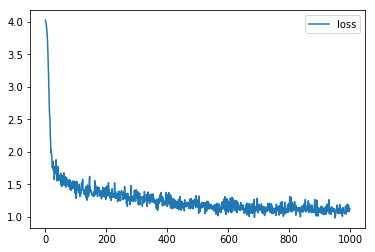

In [23]:
from IPython.display import clear_output
from random import sample

s.run(tf.global_variables_initializer())

batch_size = 32
history = []

for i in range(1000):
    batch = to_matrix(sample(names, batch_size), max_len=MAX_LENGTH)
    loss_i, _ = s.run([loss, optimize], {input_sequence: batch})
    
    history.append(loss_i)
    
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history, label='loss')
        plt.legend()
        plt.show()

# RNN: sampling

Теперь сгенерируем имена обученной нейросеткой

In [24]:
# without prefix
for _ in range(25):
    print(generate_sample())

 Buonthedann
 Teeranse
 Aonray
 Rifnliri
 Sriresa
 Regalia
 Honda
 Efinn
 Moirhy
 Seri
 Sduafcis
 Budjere
 Sotkiy
 Lhini
 Lona
 Tys
 Fssi
 Bnancol
 Wosslie
 Degma
 Beadong
 Monhtud
 Damon
 Gegne
 Cuzbieg


In [25]:
# without prefix
for _ in range(25):
    A = generate_sample()
    print(A)
    print(A in names)
    print('\n')

 Deyna
False


 Jhadmaedl
False


 Sinlitota
False


 Ralesa
False


 Maener
False


 Rhiry
False


 Garlhin
False


 Risralan
False


 Aennu
False


 Marhien
False


 Jeunt
False


 Tenlhl
False


 Dosta
False


 Mayt
False


 Yangeisa
False


 Miney
False


 Asa
False


 Zenhan
False


 Montinenre
False


 Loina
False


 Grthrecy
False


 Erdinisth
False


 Sherrarau
False


 Suukan
False


 Ennie
False




In [26]:
# with prefix conditioning
for _ in range(10):
    print(generate_sample(' Denis'))

 Denisleale
 Denishi
 Denishi
 Denisdy
 Denis
 Denisa
 Denis
 DenisanA
 Denise
 Denisdha
